# Homework 1 of Optimization for Data Science


Alberto Rossetto, Adriano Rasetta

In [ ]:
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random 
import time

np.random.seed(0)

# Similarity Computation

Choose a proper similarity measure to define w_ij (label and unlabel sample weights) and w_bar_ij (unlabeled sample weights)

We define the similarity measure and compute the two similarity matrices (unlabel vs unlabel and label vs unlabel).

In [ ]:
# Similarity measure

# CUSTUMIZED VERSION: high similarity between points, high value
def euclidean_distance(p1, p2): 
  '''
    input: two vector of n-dimension
    output: the (customized) euclidean distance between the two vector
  '''
  
  d = np.sum((p1 - p2)**2)
  return 1/((d**0.5) + 1)


In [ ]:
# Similarity matrix (we have a function as argument to enable the use of other similarity measures)

def similarity_matrix(df1, df2, similarity_measure):
  '''
    input: two dataframes and a similarity measure
    output: similarity matrix
  '''

  # Transform the dataframe in a numpy ndarray
  df1 = df1.to_numpy()
  df2 = df2.to_numpy()

  similarity_matrix = np.zeros((df1.shape[0], df2.shape[0]))

  # For unlabeled datasets
  if df1.shape == df2.shape:
      for i in range(df1.shape[0]):
        for j in range(i+1, df1.shape[0]):
            similarity_matrix[i,j] = similarity_measure(df1[i], df1[j])
            similarity_matrix[j,i] = similarity_matrix[i,j]

  # For labeled and unlabeled dataset
  else:
    for i in range(df1.shape[0]):
      for j in range(df2.shape[0]):
        similarity_matrix[i,j] = similarity_measure(df1[i], df2[j])

  return similarity_matrix

# Minimization problem

The problem we have to solve is the following:
$$ \min_{y \in R^\mu} f(y) = \min_{y \in R^\mu} \sum_{i=1}^{l} \sum_{j=1}^{\mu} w_{ij}(y^j - \bar{y}^i)^2 + \frac{1}{2} \sum_{i=1}^{\mu} \sum_{j=1}^{\mu} \bar{w}_{ij}(y^j - {y}^i)^2 $$

In [ ]:
# Problem to solve

def function_to_minimize(y_vector, w, w_bar, labels):
  '''
  input: y vector (n*1), w similarity matrix (m*n), w_bar similarity matrix (n*n), labels (m*1)
  output: function value of our minimization problem (scalar)
  '''
  # Term 1 (labeled and unlabeled)
  term_1 = 0
  for i in range(w.shape[0]):
      for j in range(w.shape[1]):
          term_1 += w[i,j] * (y_vector[j] - labels[i])**2

  # Term 2 (unlabeled)
  term_2 = 0
  for i in range(w_bar.shape[0]):
      for j in range(w_bar.shape[0]):
          term_2 += w_bar[i,j] * (y_vector[i] - y_vector[j])**2  

  return term_1 + 0.5 * term_2

# Optimization Algorithms
- Gradient descent method
- BCGD with cyclic rule
- BCGD with randomized rule



The gradient has this form:

$$ \frac{\partial f(y)}{\partial y^j} = 2 \sum_{i=1}^{l} w_{ij}(y^j - \bar{y}^i) + 2 \sum_{i=1}^{\mu} \bar{w}_{ij}(y^j - {y}^i) $$


In [ ]:
# Gradient function

def gradient(y_vector, labels, w, w_bar, ind = None):
  '''
    input: y vector (n*1), labels (m*1), similarity matrix w (m*n), similarity matrix w_bar (n*n), index of the component to update (for BCGD)
    output: gradient (n*1)
  '''
  gradient = np.zeros(len(y_vector))
  
  if ind:
     gradient[ind] = 2 * np.sum(w[:, ind] * (y_vector[ind] - labels)) + 2 * np.sum(w_bar[:, ind] * (y_vector[ind] - y_vector))

  else:
    iter = range(len(y_vector))

    for j in iter:
      gradient[j] = 2 * np.sum(w[:,j] * (y_vector[j] - labels)) + 2 * np.sum(w_bar[:,j] * (y_vector[j] - y_vector))

  return gradient

## Gradient descent method

In [ ]:
# Gradient descent function

def gradient_descent(initial_vector, labels, w, w_bar, iter, alpha, compute_func_every, threshold):
  '''
    input: initial vector (n*1), label vector (m*1), w similarity matrix (m*n), w_bar similarity matrix (n*n), number of iterations, 
           alpha, compute the function every x iterations, threshold for the stopping criterion
    output: y vector (n*1), function values list
  '''
  time_values = [] # time history
  iteration_values = [] #iteration history
  start_time = time.time()
  time_values.append(0)
  iteration_values.append(0)
  y_vector = initial_vector # Starting vector
  function_values = [function_to_minimize(y_vector, w, w_bar, labels)] # Starting point of our function

  for it in range(iter):
      
      y_vector = y_vector - alpha * gradient(y_vector, labels, w, w_bar)
      
      if it % compute_func_every == compute_func_every - 1: # We compute and print the function to minimize only after every "compute_func_every" iterations 
        function_values.append(function_to_minimize(y_vector, w, w_bar, labels))
        print(f"Function value on iteration {it + 1}: {function_values[-1]}")
        time_values.append(time.time() - start_time)
        iteration_values.append(it+1)
      
        if abs(function_values[-2] - function_values[-1]) < threshold: # Stopping criterion
          break  
      
  y_vector = np.sign(y_vector) 

  return y_vector, function_values, time_values, iteration_values

## BCGD Methods

### Cyclic

In [ ]:
# Cyclic BCGD method function

def cyclic_BCGD(initial_vector, labels, w, w_bar, iter, alpha, compute_func_every, threshold):
  '''
    input: initial vector (n*1), label vector (m*1), w similarity matrix (m*n), w_bar similarity matrix (n*n), number of iterations, 
           alpha, ompute the function every x iterations, threshold for the stopping criterion
    output: y vector (n*1), function values list 
  '''
  time_values = []
  iteration_values = []
  start_time = time.time()
  time_values.append(0)
  iteration_values.append(0)
  y_vector = np.array(initial_vector, dtype= float) # Starting vector
  function_values = [function_to_minimize(y_vector, w, w_bar, labels)] # Starting point respect our problem
  U_matrix = np.identity(y_vector.shape[0]) # Identity matrix (n*n)
  
  for it in range(iter):


    for b in range(y_vector.shape[0]): 

      y_vector[b] = y_vector[b] - alpha * np.dot(U_matrix[b], gradient(y_vector, labels, w, w_bar, b))

    if it % compute_func_every == compute_func_every - 1: # We compute the function to minimize only after every "compute_func_every" iterations 
      function_values.append(function_to_minimize(y_vector, w, w_bar, labels))
      print(f"Function value on iteration {it + 1}: {function_values[-1]}")
      time_values.append(time.time() - start_time)
      iteration_values.append(it+1)
    
      if abs(function_values[-2] - function_values[-1]) < threshold: # Stopping criterion
        break  

  y_vector = np.sign(y_vector) 
  return y_vector, function_values, time_values, iteration_values

### Randomized

In [ ]:
# Randomized BCGD method function

def randomized_BCGD(initial_vector, labels, w, w_bar, iter, alpha, compute_func_every, threshold):
  '''
    input: initial vector (n*1), label vector (m*1), w similarity matrix (m*n), w_bar similarity matrix (n*n), number of iterations, 
          alpha, number of iterations, alpha, compute the function every x iterations, threshold for the stopping criterion
    output: y vector (n*1), function values list
  '''
  time_values = []
  iteration_values = []
  start_time = time.time()
  time_values.append(0)
  iteration_values.append(0)
  y_vector =  np.array(initial_vector, dtype=float) # Starting vector
  function_values = [function_to_minimize(y_vector, w, w_bar, labels)] # Starting point respect our problem
  U_matrix = np.identity(y_vector.shape[0]) # Identity matrix (n*n)

  for it in range(iter):

    b = random.randint(0, y_vector.shape[0]-1)
    y_vector[b]  = y_vector[b] - alpha * np.dot(U_matrix[b], gradient(y_vector, labels, w, w_bar, b))
    
    if it % compute_func_every ==  compute_func_every - 1: # We compute the function to minimize only after every "compute_func_every" iterations 
      function_values.append(function_to_minimize(y_vector, w, w_bar, labels))
      print(f"Function value on iteration {it + 1}: {function_values[-1]}")
      time_values.append(time.time() - start_time)
      iteration_values.append(it+1)


      if abs(function_values[-2] - function_values[-1]) < threshold: # Stopping criterion
        break  
  
  y_vector = np.sign(y_vector) 
  return y_vector, function_values, time_values, iteration_values

# Experiments

## Artificial dataset

### Dataset generation

We are going to generate a set of 1000 samples with only two features (x1 and x2).

In [ ]:
# Creation of the samples (X) and the respective labels (y)
c= np.array([[12,6],[6,12]])
X, y = make_blobs(n_samples=1000, centers=c , n_features=2, random_state=0)

# Dimensions of the dataset
print("X shape: ", X.shape)
print("Label shape: ", y.shape)
# Label transformation (-1, 1)
y[y == 0] = -1
# Some samples
print("First 10 samples:\n", X[:10])
print("First 10 labels:\n", y[:10])

X shape:  (1000, 2)
Label shape:  (1000,)
First 10 samples:
 [[10.95144703  4.57998206]
 [13.76405235  6.40015721]
 [ 5.50420451 13.21657771]
 [14.11679102  4.3891216 ]
 [ 5.26912641 10.35829677]
 [ 6.9214084  12.46081448]
 [14.25930895  5.95774285]
 [ 9.76039594  6.40149906]
 [ 3.00538714 12.88093756]
 [ 5.87175803 11.72822843]]
First 10 labels:
 [-1 -1  1 -1  1  1 -1 -1  1  1]


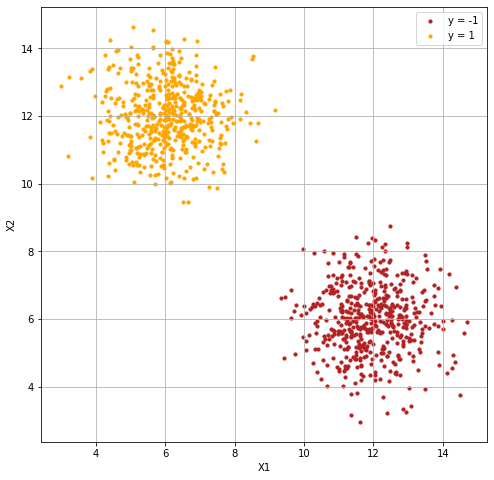

In [ ]:
# We transform and join our samples and labels in a dataframe to select the unlabeled and the labeled parts
data_dict = {'X1': X[:,0], 'X2': X[:,1], "y": y}
dataset = pd.DataFrame(data=data_dict)

# Dataset plot
color_dict = {"firebrick": -1, "orange": 1}
fig = plt.figure(figsize=(8, 8))
for color, i in color_dict.items():
    plt.scatter(dataset.X1[dataset.y == i] , dataset.X2[dataset.y == i], color = color, s=10, label = "y = %s" %i)

plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.grid()
plt.show()
fig.savefig('full_dataset.png', dpi = 300)

#### Splitting into label and unlabel

The 10% of number of points is going to be the set with the labeled points.

In [ ]:
# Labeled/unlabeled dataset creation
labeled = dataset.sample(frac = 0.1,random_state = 200)
unlabeled_with_labels = dataset.drop(labeled.index) 
unlabeled_no_labels = unlabeled_with_labels.drop(labels = 'y', axis = 1) 

In [ ]:
# Labeled and unlabeled dataset size
print("Labeled data: ", labeled.shape[0])
print("Labeled data with y = -1: ", labeled[labeled.y == -1].shape[0])
print("Labeled data with y = 1: ", labeled[labeled.y == 1].shape[0])
print("Unlabeled data : ", unlabeled_no_labels.shape[0])

Labeled data:  100
Labeled data with y = -1:  46
Labeled data with y = 1:  54
Unlabeled data :  900


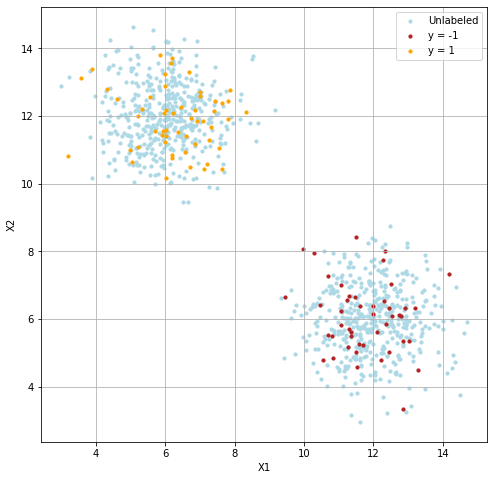

In [ ]:
# Dataset plot (lebeled/unlabeled version)
fig = plt.figure(figsize=(8, 8))
plt.scatter(unlabeled_no_labels['X1'], unlabeled_no_labels['X2'], color ='lightblue', s=10, label = "Unlabeled")
for color, i in color_dict.items():
    plt.scatter(labeled.X1[labeled.y == i], labeled.X2[labeled.y == i], c = color, s=10, label = "y = %s" %i)

plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.grid()
plt.show()
fig.savefig('divided_dataset.png', dpi = 300)

### Similarity computation

In [ ]:
# Calculation of similarity matrices. We will test our algorithms with euclidean similarity measure (customized)

# Similarity between labeled and unlabeled examples
w = similarity_matrix(labeled.iloc[:,:-1], unlabeled_no_labels, euclidean_distance)
# Similarity between unlabeled examples
w_bar = similarity_matrix(unlabeled_no_labels, unlabeled_no_labels, euclidean_distance)

### Gradient Method

In [ ]:
# INPUTS
# Starting point of y vector (random initialization: uniform distribution (-1,1))
random.seed(10)
starting_vector = np.array(random.choices([-1,1], k=unlabeled_no_labels.shape[0]))
# Vector of our labels
labels = labeled.y.to_numpy()
# Similarity matrices w and w_bar
# Number of max iterations
max_iter = 100
# Stepsize alpha
alpha_values = [0.01, 0.001, 0.0001]
# Compute the function every
compute_func_every = 1
# Threshold for the stopping criterion
threshold = 100

#### Grid search to find the stepsize


TEST NUMBER 1

Similarity measure: euclidean distance
INPUT:
Number of max iterations:  100
Stepsize:  0.01
Function value on iteration 1: 4244348.594679206
Function value on iteration 2: 81445941.1142852
Function value on iteration 3: 1640187988.6168597
Function value on iteration 4: 34105152360.910347
Function value on iteration 5: 726466123332.8136
Function value on iteration 6: 15766929901936.707
Function value on iteration 7: 347325335329841.4
Function value on iteration 8: 7743630240790494.0
Function value on iteration 9: 1.7435680031259293e+17
Function value on iteration 10: 3.958259178255311e+18
Function value on iteration 11: 9.048640143788514e+19
Function value on iteration 12: 2.0808241870844427e+21
Function value on iteration 13: 4.809580309843472e+22
Function value on iteration 14: 1.1166374039396136e+24
Function value on iteration 15: 2.602647892048903e+25
Function value on iteration 16: 6.087266953327382e+26
Function value on iteration 17: 1.4281385432520984e+28
Functio

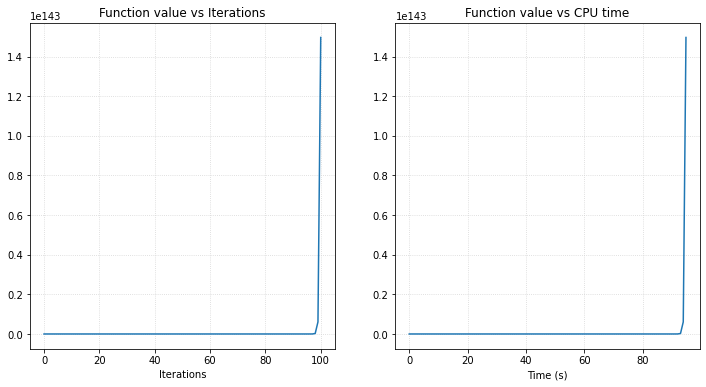

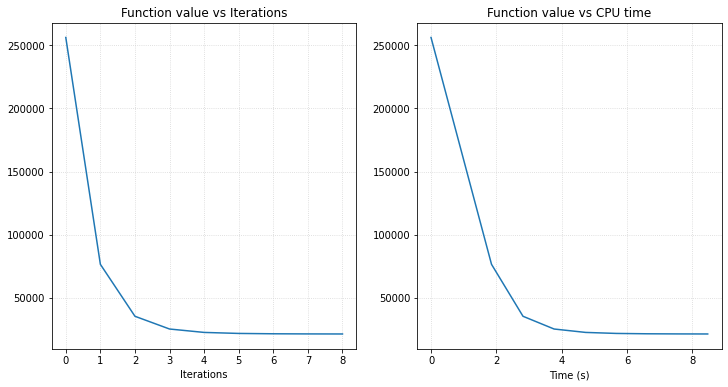

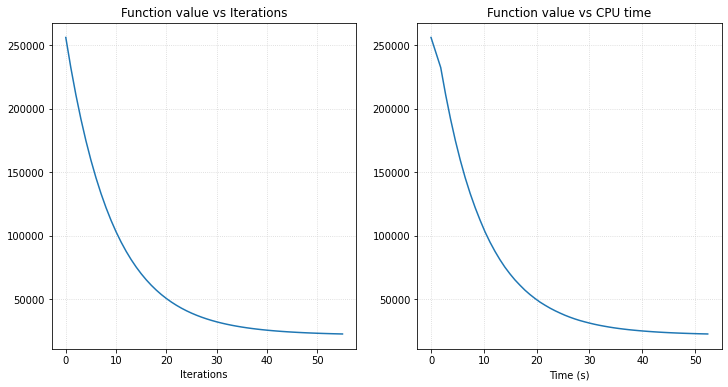

In [ ]:
# Grid search gradient descent

# Best function values after the grid search for the stepsize. List of tuples with best value and stepsize
best_function_values = []

for num_test, alpha in enumerate(alpha_values):
  # Tests gradient descent

  print(f"\nTEST NUMBER {num_test + 1}\n")
  print("Similarity measure: euclidean distance")
  print("INPUT:")
  print("Number of max iterations: ", max_iter)
  print("Stepsize: ", alpha)

  y_vector, function_values, time_values, iteration_values = gradient_descent(starting_vector, labels, w, w_bar, max_iter, alpha, compute_func_every, threshold)
  
  best_function_values.append((function_values[-1], alpha))

  # Results
  print("\nNumber of correct labels:", sum(y_vector == unlabeled_with_labels.y.to_numpy()))  
  print("Minimum function value reached:", np.min(function_values))

  fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, figsize=(12,6))
  ax1.set_title(f"Function value vs Iterations")
  ax2.set_title("Function value vs CPU time")
  ax1.plot(iteration_values, function_values)
  ax2.plot(time_values, function_values)
  ax1.grid(color='lightgrey' , linestyle=':')
  ax2.grid(color='lightgrey' , linestyle=':')
  ax1.set_xlabel("Iterations")
  ax2.set_xlabel("Time (s)")
  fig.show()

best_alpha = min(best_function_values)[1]
print(f"\n\nBEST VALUE FUNCTION: {min(best_function_values)[0]}, BEST STEPSIZE: {best_alpha}\n\n")

In [ ]:
# INPUTS
# Starting point of y vector (random initialization: uniform distribution (-1,1))
random.seed(10)
starting_vector = np.array(random.choices([-1,1], k=unlabeled_no_labels.shape[0]))
# Vector of our labels
labels = labeled.y.to_numpy()
# Similarity matrices w and w_bar
# Number of max iterations
max_iter = 50
# Stepsize alpha
alpha = best_alpha
# Compute the function every
compute_func_every = 1
# Threshold for the stopping criterion
threshold = 100


Similarity measure: euclidean distance
INPUT:
Number of max iterations:  50
Stepsize:  0.001
Function value on iteration 1: 76573.68132982144
Function value on iteration 2: 35469.16645647727
Function value on iteration 3: 25391.625009560583
Function value on iteration 4: 22698.329548035315
Function value on iteration 5: 21896.005244935102
Function value on iteration 6: 21623.72214437052
Function value on iteration 7: 21517.206946350638
Function value on iteration 8: 21469.442134069406

Number of correct labels: 899
Minimum function value reached: 21469.442134069406


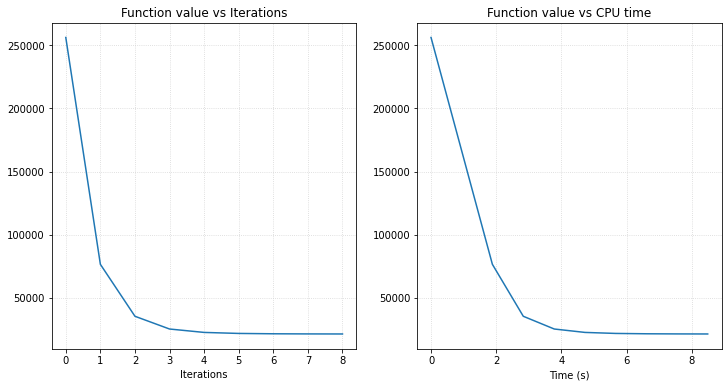

In [ ]:
# Tests gradient descent

print("\nSimilarity measure: euclidean distance")
print("INPUT:")
print("Number of max iterations: ", max_iter)
print("Stepsize: ", alpha)

y_vector_gm, function_values_gm, time_values_gm, iteration_values_gm = gradient_descent(starting_vector, labels, w, w_bar, max_iter, alpha, compute_func_every, threshold)

# Results
print("\nNumber of correct labels:", sum(y_vector_gm == unlabeled_with_labels.y.to_numpy()))  
print("Minimum function value reached:", np.min(function_values_gm))

fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, figsize=(12,6))
ax1.set_title(f"Function value vs Iterations")
ax2.set_title("Function value vs CPU time")
ax1.plot(iteration_values_gm, function_values_gm)
ax2.plot(time_values_gm, function_values_gm)
ax1.grid(color='lightgrey' , linestyle=':')
ax2.grid(color='lightgrey' , linestyle=':')
ax1.set_xlabel("Iterations")
ax2.set_xlabel("Time (s)")
fig.show()
fig.savefig('gradient_method_artificial.png', dpi = 300)

### BCGD with cyclic rule

In [ ]:
# INPUTS
# Starting point of y vector (random initialization: uniform distribution (-1,1))
random.seed(10)
starting_vector = np.array(random.choices([-1,1], k=unlabeled_no_labels.shape[0]))
# Vector of our labels
labels = labeled.y.to_numpy()
# Similarity matrices w and w_bar
# Number of max iterations
max_iter = 50
# Stepsize alpha
alpha = best_alpha
# Compute the function every
compute_func_every = 1
# Threshold for the stopping criterion
threshold = 100


Similarity measure: euclidean distance
INPUT:
Number of max iterations:  50
Stepsize:  0.001
Function value on iteration 1: 76473.10724450108
Function value on iteration 2: 35320.34258455765
Function value on iteration 3: 25255.401061153058
Function value on iteration 4: 22591.728118068582
Function value on iteration 5: 21817.770792152533
Function value on iteration 6: 21567.74240895339
Function value on iteration 7: 21477.28005066516

Number of correct labels: 894
Minimum function value reached: 21477.28005066516


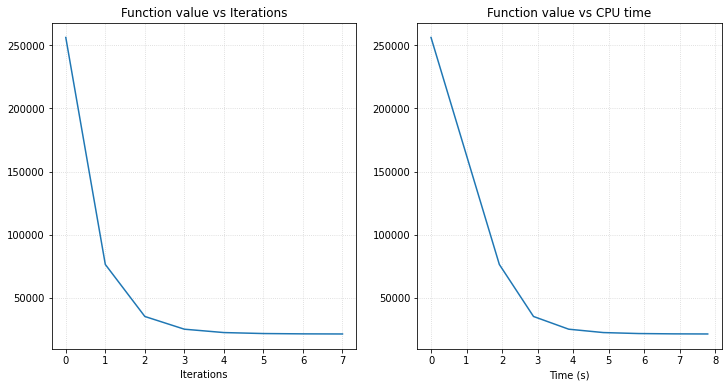

In [ ]:
# Tests cyclic BCGD

print("\nSimilarity measure: euclidean distance")
print("INPUT:")
print("Number of max iterations: ", max_iter)
print("Stepsize: ", alpha)

y_vector_cyclic, function_values_cyclic, time_values_cyclic, iteration_values_cyclic = cyclic_BCGD(starting_vector, labels, w, w_bar, max_iter, alpha, compute_func_every, threshold)

# Results
print("\nNumber of correct labels:", sum(y_vector_cyclic == unlabeled_with_labels.y.to_numpy()))  
print("Minimum function value reached:", np.min(function_values_cyclic))

fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, figsize=(12,6))
ax1.set_title(f"Function value vs Iterations")
ax2.set_title("Function value vs CPU time")
ax1.plot(iteration_values_cyclic, function_values_cyclic)
ax2.plot(time_values_cyclic, function_values_cyclic)
ax1.grid(color='lightgrey' , linestyle=':')
ax2.grid(color='lightgrey' , linestyle=':')
ax1.set_xlabel("Iterations")
ax2.set_xlabel("Time (s)")
fig.show()
fig.savefig('cyclic_method_artificial.png', dpi = 300)

### BCGD with randomized rule

In [ ]:
# INPUTS
# Starting point of y vector (random initialization: uniform distribution (-1,1))
random.seed(10)
starting_vector = np.array(random.choices([-1,1], k=unlabeled_no_labels.shape[0]))
# Vector of our labels
labels = labeled.y.to_numpy()
# Similarity matrices w and w_bar
# Number of max iterations
max_iter = 15000
# Stepsize alpha
alpha = best_alpha
# Compute the function every
compute_func_every = 2500
# Threshold for the stopping criterion
threshold = 100


Similarity measure: euclidean distance
INPUT:
Number of max iterations:  15000
Stepsize:  0.001
Function value on iteration 2500: 49439.04445904807
Function value on iteration 5000: 24578.211001711763
Function value on iteration 7500: 22013.6423500291
Function value on iteration 10000: 21452.65043083553
Function value on iteration 12500: 21411.530697326973

Number of correct labels: 900
Minimum function value reached: 21411.530697326973


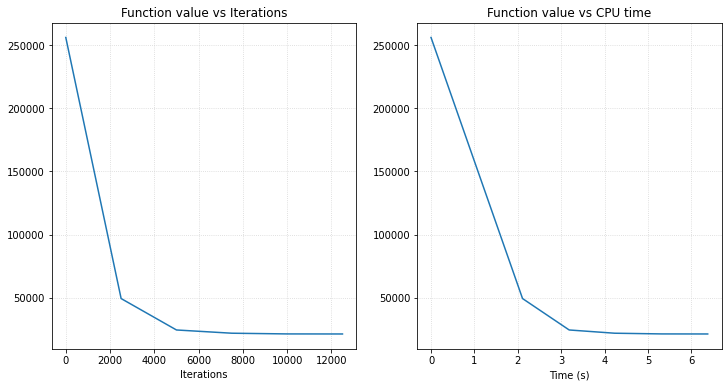

In [ ]:
# Tests randomized BCGD

print("\nSimilarity measure: euclidean distance")
print("INPUT:")
print("Number of max iterations: ", max_iter)
print("Stepsize: ", alpha)

y_vector_randomized, function_values_randomized, time_values_randomized, iteration_values_randomized = randomized_BCGD(starting_vector, labels, w, w_bar, max_iter, alpha, compute_func_every, threshold)

# Results
print("\nNumber of correct labels:", sum(y_vector_randomized == unlabeled_with_labels.y.to_numpy()))  
print("Minimum function value reached:", np.min(function_values_randomized))

fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, figsize=(12,6))
ax1.set_title(f"Function value vs Iterations")
ax2.set_title("Function value vs CPU time")
ax1.plot(iteration_values_randomized, function_values_randomized)
ax2.plot(time_values_randomized, function_values_randomized)
ax1.grid(color='lightgrey' , linestyle=':')
ax2.grid(color='lightgrey' , linestyle=':')
ax1.set_xlabel("Iterations")
ax2.set_xlabel("Time (s)")
fig.show()
fig.savefig('randomized_method_artificial.png', dpi = 300)

### Comparison of algorithms

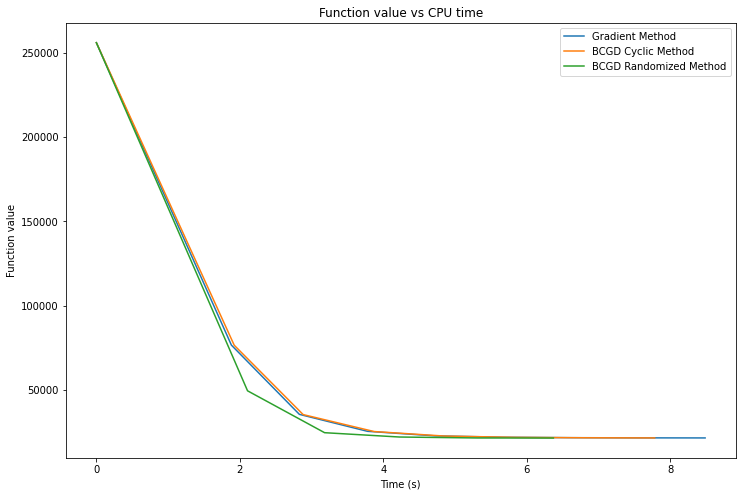

In [ ]:
# Function value vs CPU time of three algorithms

fig = plt.figure(figsize=(12,8))
plt.plot(time_values_gm, function_values_gm, label = 'Gradient Method')
plt.plot(time_values_cyclic, function_values_cyclic, label = 'BCGD Cyclic Method')
plt.plot(time_values_randomized, function_values_randomized, label = 'BCGD Randomized Method')
plt.title("Function value vs CPU time")
plt.xlabel('Time (s)')
plt.ylabel('Function value')
plt.legend()
plt.show()
fig.savefig('comparison_time_artificial.png', dpi = 300)

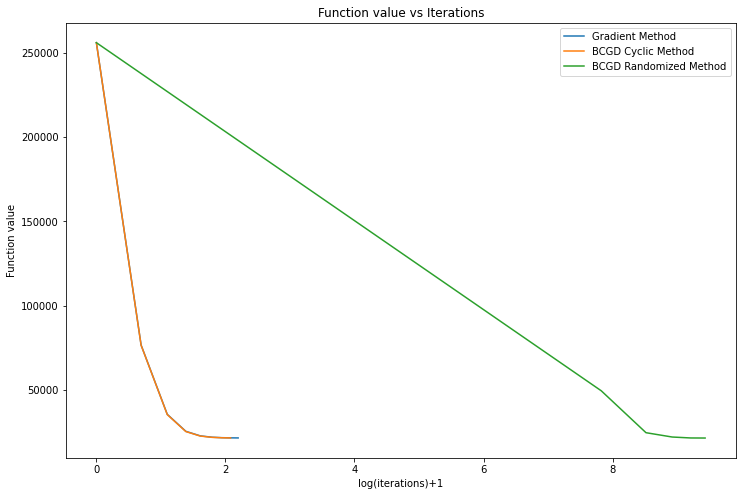

In [ ]:
# Number of iteration vs CPU time of three algorithms

fig = plt.figure(figsize=(12,8))
plt.plot(np.log(np.array(iteration_values_gm)+1), function_values_gm, label = 'Gradient Method')
plt.plot(np.log(np.array(iteration_values_cyclic)+1), function_values_cyclic, label = 'BCGD Cyclic Method')
plt.plot(np.log(np.array(iteration_values_randomized)+1), function_values_randomized, label = 'BCGD Randomized Method')
plt.title("Function value vs Iterations")
plt.xlabel('log(iterations)+1')
plt.ylabel('Function value')
plt.legend()
plt.show()
fig.savefig('comparison_iterations__artificial.png', dpi = 300)

## Real dataset

In [ ]:
from google.colab import files # this is the command used to import in a Colab Notebook the CSV
uploaded = files.upload()

Saving Rice_Osmancik_Cammeo_Dataset.xlsx to Rice_Osmancik_Cammeo_Dataset.xlsx


In [ ]:
dataset = pd.read_excel('Rice_Osmancik_Cammeo_Dataset.xlsx')

In [ ]:
dataset.head()

,AREA,PERIMETER,MAJORAXIS,MINORAXIS,ECCENTRICITY,CONVEX_AREA,EXTENT,CLASS
0,15231,525.578979,229.749878,85.093788,0.928882,15617,0.572896,Cammeo
1,14656,494.311005,206.020065,91.730972,0.895405,15072,0.615436,Cammeo
2,14634,501.122009,214.106781,87.768288,0.912118,14954,0.693259,Cammeo
3,13176,458.342987,193.337387,87.448395,0.891861,13368,0.640669,Cammeo
4,14688,507.166992,211.743378,89.312454,0.906691,15262,0.646024,Cammeo


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3810 entries, 0 to 3809
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AREA          3810 non-null   int64  
 1   PERIMETER     3810 non-null   float64
 2   MAJORAXIS     3810 non-null   float64
 3   MINORAXIS     3810 non-null   float64
 4   ECCENTRICITY  3810 non-null   float64
 5   CONVEX_AREA   3810 non-null   int64  
 6   EXTENT        3810 non-null   float64
 7   CLASS         3810 non-null   object 
dtypes: float64(5), int64(2), object(1)
memory usage: 238.2+ KB


##### Data pre-processing

In [ ]:
# Assigning discrete values to the response variable: 
# Cammeo = -1
# Osmancik = 1

dataset.CLASS = pd.Series([-1 if i=='Cammeo' else 1 for i in dataset.CLASS])
dataset.head()

,AREA,PERIMETER,MAJORAXIS,MINORAXIS,ECCENTRICITY,CONVEX_AREA,EXTENT,CLASS
0,15231,525.578979,229.749878,85.093788,0.928882,15617,0.572896,-1
1,14656,494.311005,206.020065,91.730972,0.895405,15072,0.615436,-1
2,14634,501.122009,214.106781,87.768288,0.912118,14954,0.693259,-1
3,13176,458.342987,193.337387,87.448395,0.891861,13368,0.640669,-1
4,14688,507.166992,211.743378,89.312454,0.906691,15262,0.646024,-1


In [ ]:
# Splitting the dataset and removing the labels

labeled = dataset.sample(frac = 0.1,random_state = 200)
unlabeled_with_labels = dataset.drop(labeled.index) 
unlabeled_no_labels = unlabeled_with_labels.drop(labels = 'CLASS', axis = 1) 

##### Similarity computation

In [ ]:
# Similarity matrices w and w_bar

# Similarity between labeled and unlabeled examples
w = similarity_matrix(labeled.iloc[:,:-1], unlabeled_no_labels, euclidean_distance)
# Similarity between unlabeled examples
w_bar = similarity_matrix(unlabeled_no_labels, unlabeled_no_labels, euclidean_distance)

#### Grid search to find the stepsize

In [ ]:
# INPUTS
# Starting point of y vector (random initialization: uniform distribution (-1,1))
random.seed(10)
starting_vector = np.array(random.choices([-1,1], k=unlabeled_no_labels.shape[0]))
# Vector of our labels
labels = labeled.CLASS.to_numpy()
# Number of max iterations
max_iter = 100
# Stepsize alpha
alpha_values = [0.01, 0.001, 0.0001]
# Compute the function every
compute_func_every = 25
# Threshold for the stopping criterion
threshold = 1


TEST NUMBER 1

Similarity measure: euclidean distance
INPUT:
Number of max iterations:  100
Stepsize:  0.01
Function value on iteration 25: 1600.814948084896
Function value on iteration 50: 1333.0618452225115
Function value on iteration 75: 1298.5452313039216
Function value on iteration 100: 1287.8106607538368

Number of correct labels: 2943
Minimum function value reached: 1287.8106607538368

TEST NUMBER 2

Similarity measure: euclidean distance
INPUT:
Number of max iterations:  100
Stepsize:  0.001
Function value on iteration 25: 10753.23220258417
Function value on iteration 50: 7324.457350310769
Function value on iteration 75: 5206.040301861191
Function value on iteration 100: 3879.884476764899

Number of correct labels: 1708
Minimum function value reached: 3879.884476764899

TEST NUMBER 3

Similarity measure: euclidean distance
INPUT:
Number of max iterations:  100
Stepsize:  0.0001
Function value on iteration 25: 15677.135233445206
Function value on iteration 50: 15017.66587164203

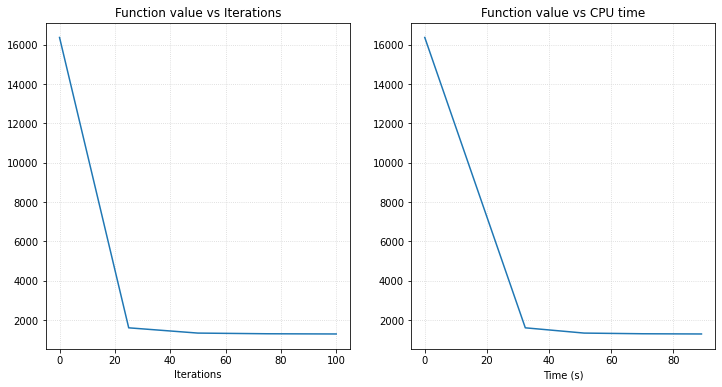

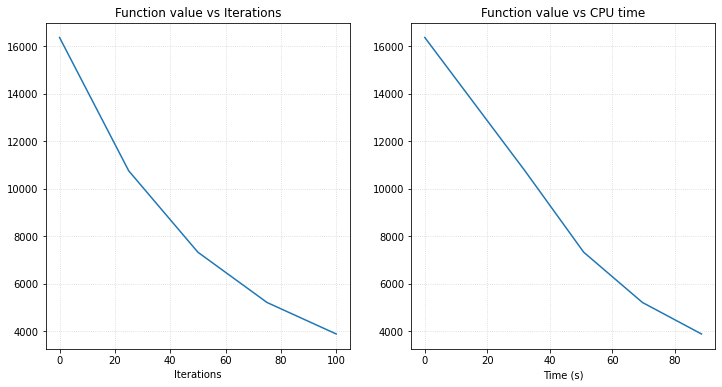

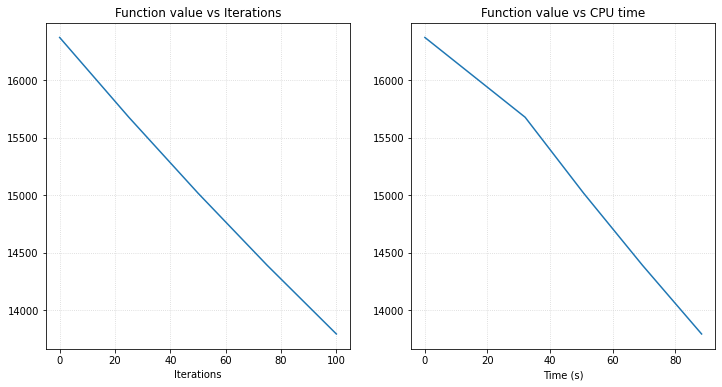

In [ ]:
# Grid search gradient descent

# Best function values after the grid search for the stepsize. List of tuples with best value and stepsize
best_function_values = []

for num_test, alpha in enumerate(alpha_values):
  # Tests gradient descent
   
  print(f"\nTEST NUMBER {num_test + 1}\n")
  print("Similarity measure: euclidean distance")
  print("INPUT:")
  print("Number of max iterations: ", max_iter)
  print("Stepsize: ", alpha)

  y_vector, function_values, time_values, iteration_values = gradient_descent(starting_vector, labels, w, w_bar, max_iter, alpha, compute_func_every, threshold)
  
  best_function_values.append((function_values[-1], alpha))

  # Results
  print("\nNumber of correct labels:", sum(y_vector == unlabeled_with_labels.CLASS.to_numpy()))  
  print("Minimum function value reached:", np.min(function_values))

  fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, figsize=(12,6))
  ax1.set_title(f"Function value vs Iterations")
  ax2.set_title("Function value vs CPU time")
  ax1.plot(iteration_values, function_values)
  ax2.plot(time_values, function_values)
  ax1.grid(color='lightgrey' , linestyle=':')
  ax2.grid(color='lightgrey' , linestyle=':')
  ax1.set_xlabel("Iterations")
  ax2.set_xlabel("Time (s)")
  fig.show()

best_alpha = min(best_function_values)[1]
print(f"\n\nBEST VALUE FUNCTION: {min(best_function_values)[0]}, BEST STEPSIZE: {best_alpha}\n\n")

#### Gradient Method


Similarity measure: euclidean distance
INPUT:
Number of max iterations:  200
Stepsize:  0.01
Function value on iteration 40: 1373.5263563231356
Function value on iteration 80: 1295.4949040294935
Function value on iteration 120: 1283.8364544562899
Function value on iteration 160: 1280.0728967388134
Function value on iteration 200: 1278.463326839444

Number of correct labels: 2892
Minimum function value reached: 1278.463326839444


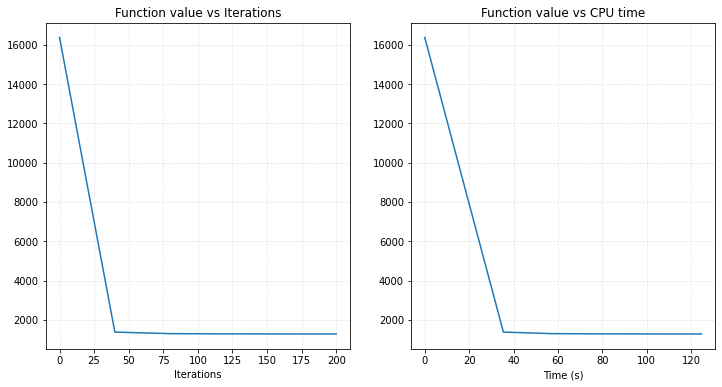

In [ ]:
# Tests gradient descent

# INPUTS
# Starting point of y vector (random initialization: uniform distribution (-1,1))
random.seed(10)
starting_vector = np.array(random.choices([-1,1], k=unlabeled_no_labels.shape[0]))
# Vector of our labels
labels = labeled.CLASS.to_numpy()
# Number of max iterations
max_iter = 200
# Stepsize alpha
alpha = best_alpha
# Compute the function every
compute_func_every = 40
# Threshold for the stopping criterion
threshold = 1

print("\nSimilarity measure: euclidean distance")
print("INPUT:")
print("Number of max iterations: ", max_iter)
print("Stepsize: ", alpha)

y_vector_gm, function_values_gm, time_values_gm, iteration_values_gm = gradient_descent(starting_vector, labels, w, w_bar, max_iter, alpha, compute_func_every, threshold)

# Results
print("\nNumber of correct labels:", sum(y_vector_gm == unlabeled_with_labels.CLASS.to_numpy()))  
print("Minimum function value reached:", np.min(function_values_gm))
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, figsize=(12,6))
ax1.set_title(f"Function value vs Iterations")
ax2.set_title("Function value vs CPU time")
ax1.plot(iteration_values_gm, function_values_gm)
ax2.plot(time_values_gm, function_values_gm)
ax1.grid(color='lightgrey' , linestyle=':')
ax2.grid(color='lightgrey' , linestyle=':')
ax1.set_xlabel("Iterations")
ax2.set_xlabel("Time (s)")
fig.show()
fig.savefig('gradient_method_real.png', dpi = 300)

#### BCGD with cyclic rule


Similarity measure: euclidean distance
INPUT:
Number of max iterations:  200
Stepsize:  0.01
Function value on iteration 40: 1371.5037085030299
Function value on iteration 80: 1294.4731753400565
Function value on iteration 120: 1283.2661957975859
Function value on iteration 160: 1279.734997867359
Function value on iteration 200: 1278.2616857563103

Number of correct labels: 2876
Minimum function value reached: 1278.2616857563103


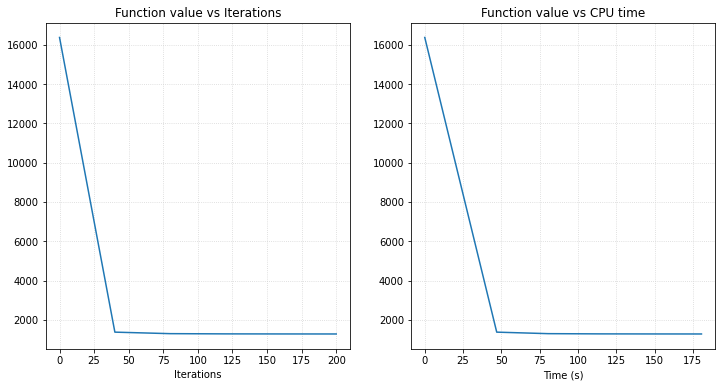

In [ ]:
# Tests cyclic BCGD

# INPUTS
# Starting point of y vector (random initialization: uniform distribution (-1,1))
random.seed(10)
starting_vector = np.array(random.choices([-1,1], k=unlabeled_no_labels.shape[0]))
# Vector of our labels
labels = labeled.CLASS.to_numpy()
# Number of max iterations
max_iter = 200
# Stepsize alpha
alpha = best_alpha
# Compute the function every
compute_func_every = 40
# Threshold for the stopping criterion
threshold = 1

print("\nSimilarity measure: euclidean distance")
print("INPUT:")
print("Number of max iterations: ", max_iter)
print("Stepsize: ", alpha)

y_vector_cyclic, function_values_cyclic, time_values_cyclic, iteration_values_cyclic = cyclic_BCGD(starting_vector, labels, w, w_bar, max_iter, alpha, compute_func_every, threshold)

# Results
print("\nNumber of correct labels:", sum(y_vector_cyclic == unlabeled_with_labels.CLASS.to_numpy()))  
print("Minimum function value reached:", np.min(function_values_cyclic))
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, figsize=(12,6))
ax1.set_title(f"Function value vs Iterations")
ax2.set_title("Function value vs CPU time")
ax1.plot(iteration_values_cyclic, function_values_cyclic)
ax2.plot(time_values_cyclic, function_values_cyclic)
ax1.grid(color='lightgrey' , linestyle=':')
ax2.grid(color='lightgrey' , linestyle=':')
ax1.set_xlabel("Iterations")
ax2.set_xlabel("Time (s)")
fig.show()
fig.savefig('cyclic_method_real.png', dpi = 300)

#### BCGD with randomized rule


Similarity measure: euclidean distance
INPUT:
Number of max iterations:  500000
Stepsize:  0.01
Function value on iteration 125000: 1415.5012417493317
Function value on iteration 250000: 1300.8711724050254
Function value on iteration 375000: 1285.7268036374026
Function value on iteration 500000: 1281.0379466330755

Number of correct labels: 2947
Minimum function value reached: 1281.0379466330755


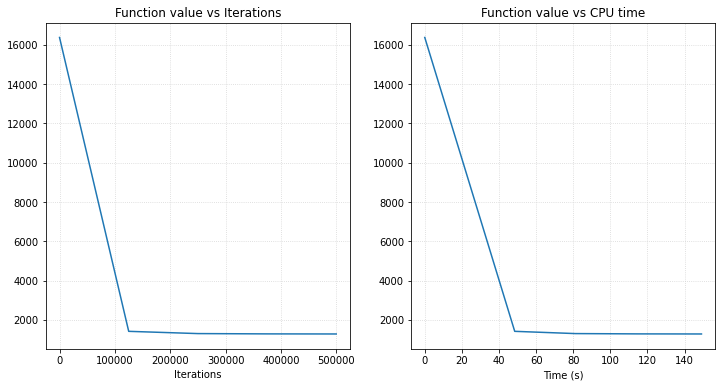

In [ ]:
# Tests randomized BCGD

# INPUTS
# Starting point of y vector (random initialization: uniform distribution (-1,1))
random.seed(10)
starting_vector = np.array(random.choices([-1,1], k=unlabeled_no_labels.shape[0]))
# Vector of our labels
labels = labeled.CLASS.to_numpy()
# Number of max iterations
max_iter = 500000
# Stepsize alpha
alpha = best_alpha
# Compute the function every
compute_func_every = 125000
# Threshold for the stopping criterion
threshold = 1

print("\nSimilarity measure: euclidean distance")
print("INPUT:")
print("Number of max iterations: ", max_iter)
print("Stepsize: ", alpha)

y_vector_randomized, function_values_randomized, time_values_randomized, iteration_values_randomized = randomized_BCGD(starting_vector, labels, w, w_bar, max_iter, alpha, compute_func_every, threshold)

# Results
print("\nNumber of correct labels:", sum(y_vector_randomized == unlabeled_with_labels.CLASS.to_numpy()))  
print("Minimum function value reached:", np.min(function_values_randomized))
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, figsize=(12,6))
ax1.set_title(f"Function value vs Iterations")
ax2.set_title("Function value vs CPU time")
ax1.plot(iteration_values_randomized, function_values_randomized)
ax2.plot(time_values_randomized, function_values_randomized)
ax1.grid(color='lightgrey' , linestyle=':')
ax2.grid(color='lightgrey' , linestyle=':')
ax1.set_xlabel("Iterations")
ax2.set_xlabel("Time (s)")
fig.show()
fig.savefig('randomized_method_real.png', dpi = 300)

#### Comparison of algorithms

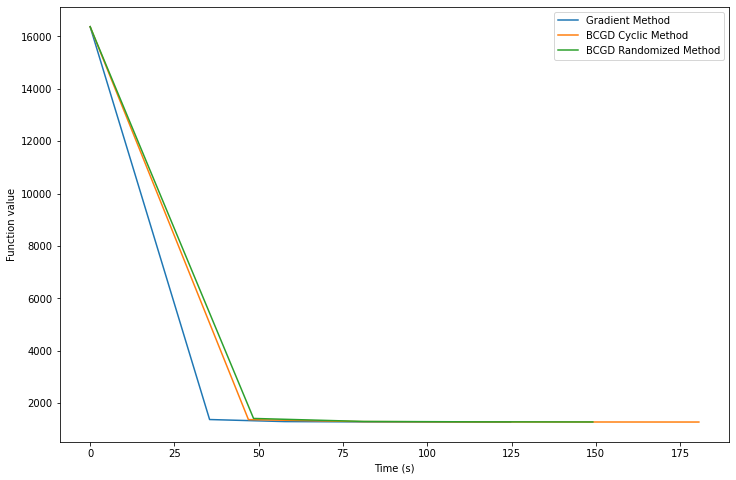

In [ ]:
# Loss vs CPU time of three algorithms

fig = plt.figure(figsize=(12,8))
plt.plot(time_values_gm, function_values_gm, label = 'Gradient Method')
plt.plot(time_values_cyclic, function_values_cyclic, label = 'BCGD Cyclic Method')
plt.plot(time_values_randomized, function_values_randomized, label = 'BCGD Randomized Method')
plt.xlabel('Time (s)')
plt.ylabel('Function value')
plt.legend()
plt.show()
fig.savefig('comparison_real.png', dpi = 300)

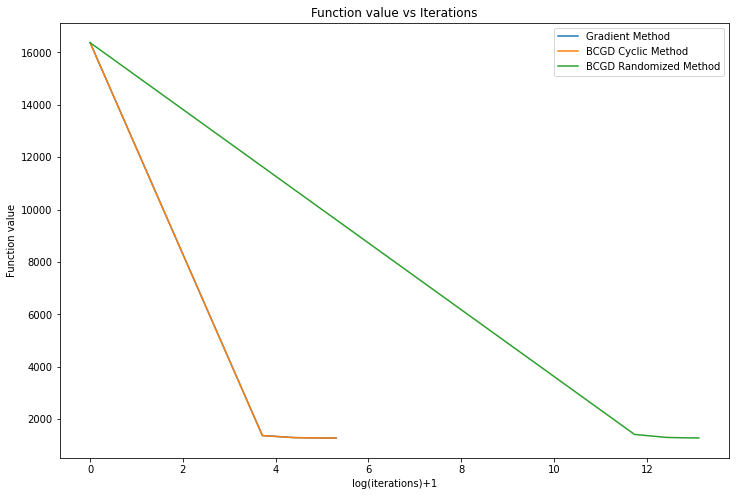

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.plot(np.log(np.array(iteration_values_gm)+1), function_values_gm, label = 'Gradient Method')
plt.plot(np.log(np.array(iteration_values_cyclic)+1), function_values_cyclic, label = 'BCGD Cyclic Method')
plt.plot(np.log(np.array(iteration_values_randomized)+1), function_values_randomized, label = 'BCGD Randomized Method')
plt.title("Function value vs Iterations")
plt.xlabel('log(iterations)+1')
plt.ylabel('Function value')
plt.legend()
plt.show()
fig.savefig('comparison_iterations_real.png', dpi = 300)